In [1]:
!pip install tables
!pip install xgboost
!pip install shap
!pip install cartopy

  Using cached tables-3.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
  Using cached numexpr-2.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (381 kB)
  Using cached blosc2-2.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.9 MB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Using cached xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl (200.3 MB)
  Using cached shap-0.41.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (572 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)


In [2]:
import pandas as pd
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import fsspec
import gcsfs
import os
import shap
import tables
import dask.dataframe as dd
import xarray as xr
import numpy as np
import requests
import time
from PIL import Image
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt


gt_id='contest_tmp2m' #'contest_tmp2m' or 'contest_precip'
target_horizon='56w' #'56w' or '34w'

from experiments_util import *
# Load functionality for fitting and predicting
from fit_and_predict import *
# Load functionality for evaluation
from skill import *
# Load stepwise utility functions
from stepwise_util import *

/srv/conda/envs/notebook/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/srv/conda/envs/notebook/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_ma

In [3]:
t=time.time()
columns=['lat','lon','start_date','tmp2m','tmp2m_anom','tmp2m_shift43', 'tmp2m_shift43_anom', 'tmp2m_shift86', 'tmp2m_shift86_anom',
                                'rhum_shift44', 'pres_shift44',
                                'nmme_wo_ccsm3_nasa', 'nmme0_wo_ccsm3_nasa','GPP_shift44','RECO_shift44','CASM_soil_moisture_shift44_y']
test=pd.read_hdf('results/regression1/shared/contest_tmp2m_56w/lat_lon_date_data-contest_tmp2m_56w.h5',key='data')
print('Loading time=',time.time()-t)


Loading time= 83.10929703712463


In [5]:
print(test)

           lat    lon  key_2  key_3 start_date  rhum_shift44  pres_shift44  \
0         27.0  261.0      1      1 1979-01-01     79.020353  98990.379046   
1         27.0  261.0      1      2 1979-01-02     78.185715  98899.980748   
2         27.0  261.0      1      3 1979-01-03     75.412714  98820.342494   
3         27.0  261.0      1      4 1979-01-04     72.435760  98775.896763   
4         27.0  261.0      1      5 1979-01-05     69.272402  98695.539062   
...        ...    ...    ...    ...        ...           ...           ...   
29740249  49.0  258.0      5     23 2019-05-23           NaN           NaN   
29740250  49.0  259.0      5     23 2019-05-23           NaN           NaN   
29740251  49.0  260.0      5     23 2019-05-23           NaN           NaN   
29740252  49.0  261.0      5     23 2019-05-23           NaN           NaN   
29740253  49.0  262.0      5     23 2019-05-23           NaN           NaN   

          GPP_shift44  RECO_shift44  Unnamed: 0_shift44_x  ... 

In [10]:
print(test_coords)

          lat    lon
0        27.0  261.0
1        27.0  261.0
2        27.0  261.0
3        27.0  261.0
4        27.0  261.0
...       ...    ...
7403463  49.0  262.0
7403464  49.0  262.0
7403465  49.0  262.0
7403466  49.0  262.0
7403467  49.0  262.0

[187610 rows x 2 columns]


In [4]:
pd.set_option('mode.chained_assignment', None)
test_coords=test[test['start_date'].dt.year==1979][['lat','lon']]
df_csif=pd.DataFrame()
t=time.time()
file_name='data/new features/OCO2.SIF.clear.inst.2000001.v2.nc'
data = xr.open_dataset(file_name)
df = data.to_dataframe().reset_index()
df['lat']=df['lat'].round()
df['lon']=df['lon'].round()
df['lon']=df['lon']+360
df=df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()
filtered_df=df[df[['lat', 'lon']].apply(lambda row: (row['lat'], row['lon']) in zip(test_coords['lat'], test_coords['lon']), axis=1)]           
filtered_df=filtered_df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()


start_date = datetime(1999, 1, 1)

target_date = start_date +timedelta(days=365-42)
filtered_df['start_date']=target_date
df_csif=filtered_df
coords=df_csif[['lat','lon']]
print(df_csif)
for year in range(2000,2019):
    if year==2000:
        for i in range(1,3):
            file_name='data/new features/OCO2.SIF.clear.inst.{}00{}.v2.nc'.format(year,1+4*i)
            data = xr.open_dataset(file_name)
            df = data.to_dataframe().reset_index()
            df['lat']=df['lat'].round()
            df['lon']=df['lon'].round()
            df['lon']=df['lon']+360
            df=df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()
            filtered_df=df[df[['lat', 'lon']].apply(lambda row: (row['lat'], row['lon']) in zip(coords['lat'], coords['lon']), axis=1)]
            filtered_df=filtered_df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()

            start_date = datetime(year-1, 1, 1)

            target_date = start_date + timedelta(days=365-(43-(1+4*i))+1)
            filtered_df['start_date']=target_date
            df_csif=pd.concat([df_csif,filtered_df],ignore_index=True)
            
        for i in range(22):
            
            file_name='data/new features/OCO2.SIF.clear.inst.{}0{}.v2.nc'.format(year,13+4*i)
            data = xr.open_dataset(file_name)
            df = data.to_dataframe().reset_index()
            df['lat']=df['lat'].round()
            df['lon']=df['lon'].round()
            df['lon']=df['lon']+360
            df=df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()
            filtered_df=df[df[['lat', 'lon']].apply(lambda row: (row['lat'], row['lon']) in zip(coords['lat'], coords['lon']), axis=1)]
            filtered_df=filtered_df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()
            if (13+4*i)<=43:
                start_date = datetime(year-1, 1, 1)

                target_date = start_date + timedelta(days=365-(43-(13+4*i))+1)
                filtered_df['start_date']=target_date
            else:
                start_date = datetime(year, 1, 1)

                target_date = start_date + timedelta(days=13+4*i-43)
                filtered_df['start_date']=target_date
            df_csif=pd.concat([df_csif,filtered_df],ignore_index=True)
            
        for i in range(67):
            
            file_name='data/new features/OCO2.SIF.clear.inst.{}{}.v2.nc'.format(year,101+4*i)
            data = xr.open_dataset(file_name)
            df = data.to_dataframe().reset_index()
            df['lat']=df['lat'].round()
            df['lon']=df['lon'].round()
            df['lon']=df['lon']+360
            df=df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()
            filtered_df=df[df[['lat', 'lon']].apply(lambda row: (row['lat'], row['lon']) in zip(coords['lat'], coords['lon']), axis=1)]
            
            filtered_df=filtered_df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()

            start_date = datetime(year, 1, 1)

            target_date = start_date + timedelta(days=101+4*i - 1-43)
            filtered_df['start_date']=target_date
            df_csif=pd.concat([df_csif,filtered_df],ignore_index=True)
            
        print('{} is done, Elapsed time={}'.format(year,time.time()-t))
    else:
        for i in range(0,3):
            
            file_name='data/new features/OCO2.SIF.clear.inst.{}00{}.v2.nc'.format(year,1+4*i)
            data = xr.open_dataset(file_name)
            df = data.to_dataframe().reset_index()
            df['lat']=df['lat'].round()
            df['lon']=df['lon'].round()
            df['lon']=df['lon']+360
            df=df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()
            filtered_df=df[df[['lat', 'lon']].apply(lambda row: (row['lat'], row['lon']) in zip(coords['lat'], coords['lon']), axis=1)]
            filtered_df=filtered_df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()
            start_date = datetime(year-1, 1, 1)

            target_date = start_date + timedelta(days=365-(43-(1+4*i))+1)
            filtered_df['start_date']=target_date
            df_csif=pd.concat([df_csif,filtered_df],ignore_index=True)
   

        for i in range(22):
         
            file_name='data/new features/OCO2.SIF.clear.inst.{}0{}.v2.nc'.format(year,13+4*i)
            data = xr.open_dataset(file_name)
            df = data.to_dataframe().reset_index()
            df['lat']=df['lat'].round()
            df['lon']=df['lon'].round()
            df['lon']=df['lon']+360
            df=df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()
            filtered_df=df[df[['lat', 'lon']].apply(lambda row: (row['lat'], row['lon']) in zip(coords['lat'], coords['lon']), axis=1)]
            filtered_df=filtered_df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()

            if (13+4*i)<=43:
                start_date = datetime(year-1, 1, 1)

                target_date = start_date + timedelta(days=365-(43-(13+4*i))+1)
                filtered_df['start_date']=target_date
            else:
                start_date = datetime(year, 1, 1)

                target_date = start_date + timedelta(days=13+4*i-43-1)
                filtered_df['start_date']=target_date
            df_csif=pd.concat([df_csif,filtered_df],ignore_index=True)
      
        for i in range(67):
     
            file_name='data/new features/OCO2.SIF.clear.inst.{}{}.v2.nc'.format(year,101+4*i)
            data = xr.open_dataset(file_name)
            df = data.to_dataframe().reset_index()
            df['lat']=df['lat'].round()
            df['lon']=df['lon'].round()
            df['lon']=df['lon']+360
            df=df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()
            filtered_df=df[df[['lat', 'lon']].apply(lambda row: (row['lat'], row['lon']) in zip(coords['lat'], coords['lon']), axis=1)]
            filtered_df=filtered_df.groupby(['lat','lon'],as_index=False)[['clear_inst_SIF','clear_daily_SIF']].mean()

            start_date = datetime(year, 1, 1)

            target_date = start_date + timedelta(days=101+4*i - 1-43)
            filtered_df['start_date']=target_date
            df_csif=pd.concat([df_csif,filtered_df],ignore_index=True)
        
        print('{} is done, Elapsed time={}'.format(year,time.time()-t))

      lat    lon  clear_inst_SIF  clear_daily_SIF start_date
0    27.0  261.0             0.0              0.0 1999-11-20
1    27.0  262.0             0.0              0.0 1999-11-20
2    28.0  261.0             0.0              0.0 1999-11-20
3    28.0  262.0             0.0              0.0 1999-11-20
4    28.0  263.0             0.0              0.0 1999-11-20
..    ...    ...             ...              ...        ...
509  49.0  258.0             0.0              0.0 1999-11-20
510  49.0  259.0             0.0              0.0 1999-11-20
511  49.0  260.0             0.0              0.0 1999-11-20
512  49.0  261.0             0.0              0.0 1999-11-20
513  49.0  262.0             0.0              0.0 1999-11-20

[514 rows x 5 columns]
2000 is done, Elapsed time=25.875128984451294
2001 is done, Elapsed time=36.108935832977295
2002 is done, Elapsed time=46.34299564361572
2003 is done, Elapsed time=56.58891820907593
2004 is done, Elapsed time=66.8323974609375
2005 is done, Elap

In [5]:
df_csif = df_csif.sort_values(by=['start_date','lat','lon'])
df_csif.reset_index(inplace=True,drop=True)


In [8]:
print(df_csif[df_csif['start_date'].dt.year==2017]['start_date'].unique())
print(len(df_csif[df_csif['start_date'].dt.year==2017]['start_date'].unique()))

<DatetimeArray>
['2017-01-02 00:00:00', '2017-01-06 00:00:00', '2017-01-10 00:00:00',
 '2017-01-14 00:00:00', '2017-01-18 00:00:00', '2017-01-22 00:00:00',
 '2017-01-26 00:00:00', '2017-01-30 00:00:00', '2017-02-03 00:00:00',
 '2017-02-07 00:00:00', '2017-02-11 00:00:00', '2017-02-15 00:00:00',
 '2017-02-19 00:00:00', '2017-02-23 00:00:00', '2017-02-27 00:00:00',
 '2017-03-03 00:00:00', '2017-03-07 00:00:00', '2017-03-11 00:00:00',
 '2017-03-15 00:00:00', '2017-03-19 00:00:00', '2017-03-23 00:00:00',
 '2017-03-27 00:00:00', '2017-03-31 00:00:00', '2017-04-04 00:00:00',
 '2017-04-08 00:00:00', '2017-04-12 00:00:00', '2017-04-16 00:00:00',
 '2017-04-20 00:00:00', '2017-04-24 00:00:00', '2017-04-28 00:00:00',
 '2017-05-02 00:00:00', '2017-05-06 00:00:00', '2017-05-10 00:00:00',
 '2017-05-14 00:00:00', '2017-05-18 00:00:00', '2017-05-22 00:00:00',
 '2017-05-26 00:00:00', '2017-05-30 00:00:00', '2017-06-03 00:00:00',
 '2017-06-07 00:00:00', '2017-06-11 00:00:00', '2017-06-15 00:00:00',
 '20

In [43]:
print(df_csif)
print(test)

         lat    lon  clear_inst_SIF  clear_daily_SIF start_date
0       27.0  261.0        0.000000         0.000000 2000-01-01
1       27.0  262.0        0.000000         0.000000 2000-01-01
2       28.0  261.0        0.000000         0.000000 2000-01-01
3       28.0  262.0        0.000000         0.000000 2000-01-01
4       28.0  263.0        0.000000         0.000000 2000-01-01
...      ...    ...             ...              ...        ...
898467  49.0  258.0       -0.014141        -0.003277 2018-12-31
898468  49.0  259.0       -0.014141        -0.003277 2018-12-31
898469  49.0  260.0       -0.014141        -0.003277 2018-12-31
898470  49.0  261.0       -0.014141        -0.003277 2018-12-31
898471  49.0  262.0       -0.014141        -0.003277 2018-12-31

[898472 rows x 5 columns]
           lat    lon  key_2  key_3 start_date  rhum_shift44  pres_shift44  \
0         27.0  261.0      1      1 1979-01-01     79.020353  98990.379046   
1         27.0  261.0      1      2 1979-01-02   

In [17]:
print(df_csif)

         lat    lon  clear_inst_SIF  clear_daily_SIF start_date
0       27.0  261.0        0.000000         0.000000 2000-01-01
1       27.0  261.0        0.000000         0.000000 2000-01-01
2       27.0  261.0        0.194060         0.067389 2000-01-01
3       27.0  262.0        0.000000         0.000000 2000-01-01
4       27.0  262.0        0.000000         0.000000 2000-01-01
...      ...    ...             ...              ...        ...
898467  49.0  258.0       -0.014141        -0.003277 2018-09-22
898468  49.0  259.0       -0.014141        -0.003277 2018-09-22
898469  49.0  260.0       -0.014141        -0.003277 2018-09-22
898470  49.0  261.0       -0.014141        -0.003277 2018-09-22
898471  49.0  262.0       -0.014141        -0.003277 2018-09-22

[898472 rows x 5 columns]


In [6]:
merged_df = test.merge(df_csif, on=['lat', 'lon', 'start_date'], how='left')


In [7]:
merged_df=merged_df.dropna(subset=['tmp2m_anom'])
print(merged_df)


          lat    lon  key_2  key_3 start_date  rhum_shift44  pres_shift44  \
0        27.0  261.0      1      1 1979-01-01     79.020353  98990.379046   
1        27.0  261.0      1      2 1979-01-02     78.185715  98899.980748   
2        27.0  261.0      1      3 1979-01-03     75.412714  98820.342494   
3        27.0  261.0      1      4 1979-01-04     72.435760  98775.896763   
4        27.0  261.0      1      5 1979-01-05     69.272402  98695.539062   
...       ...    ...    ...    ...        ...           ...           ...   
7417486  49.0  262.0      5     19 2018-05-19     83.044968  98082.935965   
7417487  49.0  262.0      5     20 2018-05-20     83.193960  98171.449358   
7417488  49.0  262.0      5     21 2018-05-21     81.676531  98205.961775   
7417489  49.0  262.0      5     22 2018-05-22     81.226318  98230.463588   
7417490  49.0  262.0      5     23 2018-05-23     81.402536  98250.907227   

         GPP_shift44  RECO_shift44  Unnamed: 0_shift44_x  ...  \
0         

In [15]:
print(merged_df.columns)

Index(['lat', 'lon', 'key_2', 'key_3', 'start_date', 'rhum_shift44',
       'pres_shift44', 'GPP_shift44', 'RECO_shift44', 'Unnamed: 0_shift44_x',
       'CASM_soil_moisture_shift44_x', 'rhum_shift88', 'pres_shift88',
       'GPP_shift88', 'RECO_shift88', 'Unnamed: 0_shift44_y',
       'CASM_soil_moisture_shift44_y', 'rhum_shift365', 'pres_shift365',
       'GPP_shift365', 'RECO_shift365', 'Unnamed: 0_shift44',
       'CASM_soil_moisture_shift44', 'ccsm3', 'nasa', 'nmme_mean',
       'nmme_wo_ccsm3_nasa', 'ccsm3_0', 'nasa_0', 'nmme0_mean',
       'nmme0_wo_ccsm3_nasa', 'ccsm3_shift29', 'nasa_shift29',
       'nmme_mean_shift29', 'nmme_wo_ccsm3_nasa_shift29', 'ccsm3_0_shift29',
       'nasa_0_shift29', 'nmme0_mean_shift29', 'nmme0_wo_ccsm3_nasa_shift29',
       'tmp2m', 'tmp2m_sqd', 'tmp2m_std', 'tmp2m_clim', 'tmp2m_anom',
       'precip_shift43', 'precip_shift43_clim', 'precip_shift43_anom',
       'tmp2m_shift43', 'tmp2m_sqd_shift43', 'tmp2m_std_shift43',
       'tmp2m_shift43_clim', 

In [40]:
def xgboost_regressor_initial_training(df,gt_id,target_horizon,year):
    """
    target_date: datetime object, date à prédire
    """
    #candidate_x_cols=default_stepwise_candidate_predictors(gt_id,target_horizon)
    #candidate_x_cols=['rhum_shift44','pres_shift44',
     #   'nmme_wo_ccsm3_nasa','nmme0_wo_ccsm3_nasa',
      # 'precip_shift43','precip_shift43_anom',
       # 'tmp2m_shift43','tmp2m_shift43_anom','precip_shift86','precip_shift86_anom','tmp2m_shift86',
        #'tmp2m_shift86_anom']
    candidate_x_cols=['tmp2m_shift43', 'tmp2m_shift43_anom', 'tmp2m_shift86', 'tmp2m_shift86_anom',
                               'rhum_shift44', 'pres_shift44',
                               'nmme_wo_ccsm3_nasa', 'nmme0_wo_ccsm3_nasa'#,'coord_encoded'
                     # ,'CASM_soil_moisture_shift44_x']
                      #,'elev']
                      ,'clear_inst_SIF']
         #                      ]#+['lat','lon']
    #df['lat'] = df['lat'].astype(float)
    #df['lon'] = df['lon'].astype(float)
    
    train_data = df[(df['start_date'].dt.year != year)]
    test_data = df[df['start_date'].dt.year == year]
    
    X_train=train_data[[col for col in candidate_x_cols]]
    y_train=train_data['tmp2m_anom']
    
    X_test = test_data[[col for col in candidate_x_cols]]
    y_test_actual = test_data['tmp2m_anom']

    
 #   model=xgb.XGBRegressor(n_estimators=100,tree_method='gpu_hist',enable_categorical=True)
    model=xgb.XGBRegressor(n_estimators=100)

    model.fit(X_train,y_train)
    
    y_test_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test_actual, y_test_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, y_test_pred)
    #similarity = cosine_similarity(y_test_actual,y_test_pred)
    #y_test_actual=y_test_actual.to_numpy()
    #print(y_test_actual.reshape(-1,1))
    #print(y_test_pred.reshape(-1,1))
    #similarity = cosine_similarity(y_test_actual.reshape(-1,1),y_test_pred.reshape(-1,1))
    results = pd.DataFrame({'Date': test_data['start_date'], 'Actual Temperatures': y_test_actual, 'Predicted Temperatures': y_test_pred,
                         'RMSE':rmse,'MAE':mae})
    return y_test_actual, y_test_pred, results
    
    #return model


In [9]:
def evaluator(df,gt_id,target_horizon,year,model):

    candidate_x_cols=['tmp2m_shift43', 'tmp2m_shift43_anom', 'tmp2m_shift86', 'tmp2m_shift86_anom',
                               'rhum_shift44', 'pres_shift44',
                               'nmme_wo_ccsm3_nasa', 'nmme0_wo_ccsm3_nasa']#,'coord_encoded'
                     # ,'CASM_soil_moisture_shift44_x']
                     # ,'elev']
       # ,'clear_daily_SIF'
                  #,'clear_inst_SIF']
         #                      ]#+['lat','lon']
    test_data = df[df['start_date'].dt.year == year]
    X_test = test_data[[col for col in candidate_x_cols]]
    y_test_actual = test_data['tmp2m_anom']
    
    y_test_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test_actual, y_test_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, y_test_pred)
    #similarity = cosine_similarity(y_test_actual,y_test_pred)
    #y_test_actual=y_test_actual.to_numpy()
    #print(y_test_actual.reshape(-1,1))
    #print(y_test_pred.reshape(-1,1))
    #similarity = cosine_similarity(y_test_actual.reshape(-1,1),y_test_pred.reshape(-1,1))
    results = pd.DataFrame({'Date': test_data['start_date'], 'Actual Temperatures': y_test_actual, 'Predicted Temperatures': y_test_pred,
                         'RMSE':rmse,'MAE':mae})
    return y_test_actual, y_test_pred, results



In [11]:

# Fonction pour attribuer la saison en fonction de la date
#modifier cette fonction pour attribuer les saisons uniquement aux dates qui m'intéressent (mettre des trucs randoms pour les autres à la limite)
def assign_season(date):
    year=date.year
    spring_start = pd.to_datetime('{}-03-21'.format(year))
    summer_start = pd.to_datetime('{}-06-22'.format(year))
    autumn_start = pd.to_datetime('{}-09-22'.format(year))
    winter_start = pd.to_datetime('{}-12-21'.format(year))
    if date >= spring_start and date < summer_start:
        return 1
    elif date >= summer_start and date < autumn_start:
        return 2
    elif date >= autumn_start and date < winter_start:
        return 3
    else:
        return 4


Elapsed time= 1053.4369595050812
         lat    lon  clear_inst_SIF  clear_daily_SIF start_date  season
0       27.0  261.0        0.000000         0.000000 1999-11-20       3
1       27.0  262.0        0.000000         0.000000 1999-11-20       3
2       28.0  261.0        0.000000         0.000000 1999-11-20       3
3       28.0  262.0        0.000000         0.000000 1999-11-20       3
4       28.0  263.0        0.000000         0.000000 1999-11-20       3
...      ...    ...             ...              ...        ...     ...
898467  49.0  258.0       -0.014141        -0.003277 2018-11-18       3
898468  49.0  259.0       -0.014141        -0.003277 2018-11-18       3
898469  49.0  260.0       -0.014141        -0.003277 2018-11-18       3
898470  49.0  261.0       -0.014141        -0.003277 2018-11-18       3
898471  49.0  262.0       -0.014141        -0.003277 2018-11-18       3

[898472 rows x 6 columns]


In [38]:
df2011=pd.DataFrame()
df2012=pd.DataFrame()
df2013=pd.DataFrame()
df2014=pd.DataFrame()
df2015=pd.DataFrame()
df2016=pd.DataFrame()
df2017=pd.DataFrame()
df2018=pd.DataFrame()

In [41]:


additional_feature=True


years=[2011+i for i in range(8)]
result6=pd.DataFrame()
result6['year']=years
skills=[]
for year in years:
    t=time.time()
    df_name = 'df{}'.format(year)
    df = globals()[df_name]
    y_test_actual, y_test_pred, results= xgboost_regressor_initial_training(merged_df,gt_id,target_horizon,year)
    skill=get_col_skill(results,'Actual Temperatures','Predicted Temperatures',date_col='Date')
    skills.append(skill)
    if df.empty:
        if year==2011:

            df['start_date']=results['Date']
            df['ground truth']=results['Actual Temperatures']
            df['season'] = df['start_date'].apply(assign_season)
            df.reset_index(inplace=True,drop=True)
        else:
            df['start_date']=results['Date']
            df['ground truth']=results['Actual Temperatures']
            df.reset_index(inplace=True,drop=True)
            df['season']=df2011['season']
    if additional_feature:
        results.reset_index(inplace=True,drop=True)
        df['preds with csif']=results['Predicted Temperatures']
    else:
        results.reset_index(inplace=True,drop=True)
        df['preds without csif']=results['Predicted Temperatures']

    
    globals()[df_name] = df 
    print('{}'.format(year)+' est bon')
    print('Temps pour {}={}'.format(year,time.time()-t))

2011 est bon
Temps pour 2011=29.60779333114624
2012 est bon
Temps pour 2012=29.31430983543396
2013 est bon
Temps pour 2013=29.387067079544067
2014 est bon
Temps pour 2014=29.516383409500122
2015 est bon
Temps pour 2015=29.293294191360474
2016 est bon
Temps pour 2016=29.125408172607422
2017 est bon
Temps pour 2017=29.166656255722046
2018 est bon
Temps pour 2018=29.94807004928589


In [99]:
df2011_save=df2011.copy()
df2012_save=df2012.copy()
df2013_save=df2013.copy()
df2014_save=df2014.copy()
df2015_save=df2015.copy()
df2016_save=df2016.copy()
df2017_save=df2017.copy()

In [85]:
df2011=df2011_save.copy()
df2012=df2012_save.copy()
df2013=df2013_save.copy()
df2014=df2014_save.copy()
df2015=df2015_save.copy()
df2016=df2016_save.copy()
df2017=df2017_save.copy()

In [49]:
print(df2011)
print(get_col_skill(df2011,'preds with csif','ground truth',date_col='start_date'))
print(get_col_skill(df2011,'preds without csif','ground truth',date_col='start_date'))

       start_date  ground truth  season  preds without csif  preds with csif  \
0      2011-01-01      0.002027       4            0.638364         0.495467   
1      2011-01-02     -0.153085       4            0.769174         1.029291   
2      2011-01-03      0.052457       4            0.776860         0.676414   
3      2011-01-04      0.094665       4            0.735186         0.648973   
4      2011-01-05      0.106306       4            0.676447         0.661662   
...           ...           ...     ...                 ...              ...   
187605 2011-12-27     10.292595       4            0.133456         2.880951   
187606 2011-12-28     11.595415       4            0.551226         1.925918   
187607 2011-12-29     11.736753       4            1.842287         2.262476   
187608 2011-12-30     11.063030       4            2.180642         2.743072   
187609 2011-12-31     10.388193       4            2.994401         4.419414   

         lat    lon  
0       27.0  261

In [43]:
indexes=df_csif[['lat','lon']][0:514] 
for year in range(2011,2019):
    df_name='df{}'.format(year)
    df=globals()[df_name]
    df.reset_index(inplace=True,drop=True)
    df['lat']=indexes['lat'].repeat(365).reset_index(drop=True)
    df['lon']=indexes['lon'].repeat(365).reset_index(drop=True)
    globals()[df_name]=df

In [88]:
skills_with_csif=[]
skills_without_csif=[]
for year in range(2011,2019):
    df_name='df{}'.format(year)
    df=globals()[df_name]    
    skill=get_col_skill(df,'preds with csif','ground truth',date_col='start_date')
    skills_with_csif.append(skill)
    skill=get_col_skill(df,'preds without csif','ground truth',date_col='start_date')
    skills_without_csif.append(skill)

In [92]:
print(df2014)

       start_date  ground truth  season  preds without csif  preds with csif  \
0      2014-01-01     -0.869439       4           -0.740239        -0.491155   
1      2014-01-02     -0.750396       4           -0.600344        -0.355449   
2      2014-01-03     -0.443960       4           -0.600344        -0.559556   
3      2014-01-04      0.024678       4           -0.583281        -0.498098   
4      2014-01-05      0.056416       4           -0.836051        -0.389970   
...           ...           ...     ...                 ...              ...   
187605 2014-12-27     -4.390252       4            1.354653         1.060007   
187606 2014-12-28     -4.726212       4            1.534633         1.163000   
187607 2014-12-29     -4.472519       4            0.756226         0.867665   
187608 2014-12-30     -4.564608       4            0.687411         0.511313   
187609 2014-12-31     -4.296978       4            0.202846        -0.656568   

         lat    lon  
0       27.0  261

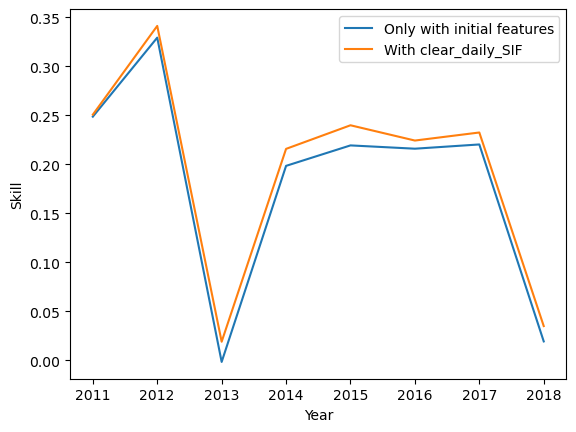

In [54]:

plt.plot(years,skills_without_csif,label='Only with initial features')
plt.plot(years,skills_with_csif,label='With clear_daily_SIF ')
#plt.plot(years,result6['skill'],label='With clear_inst_SIF only')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Skill')
plt.show()

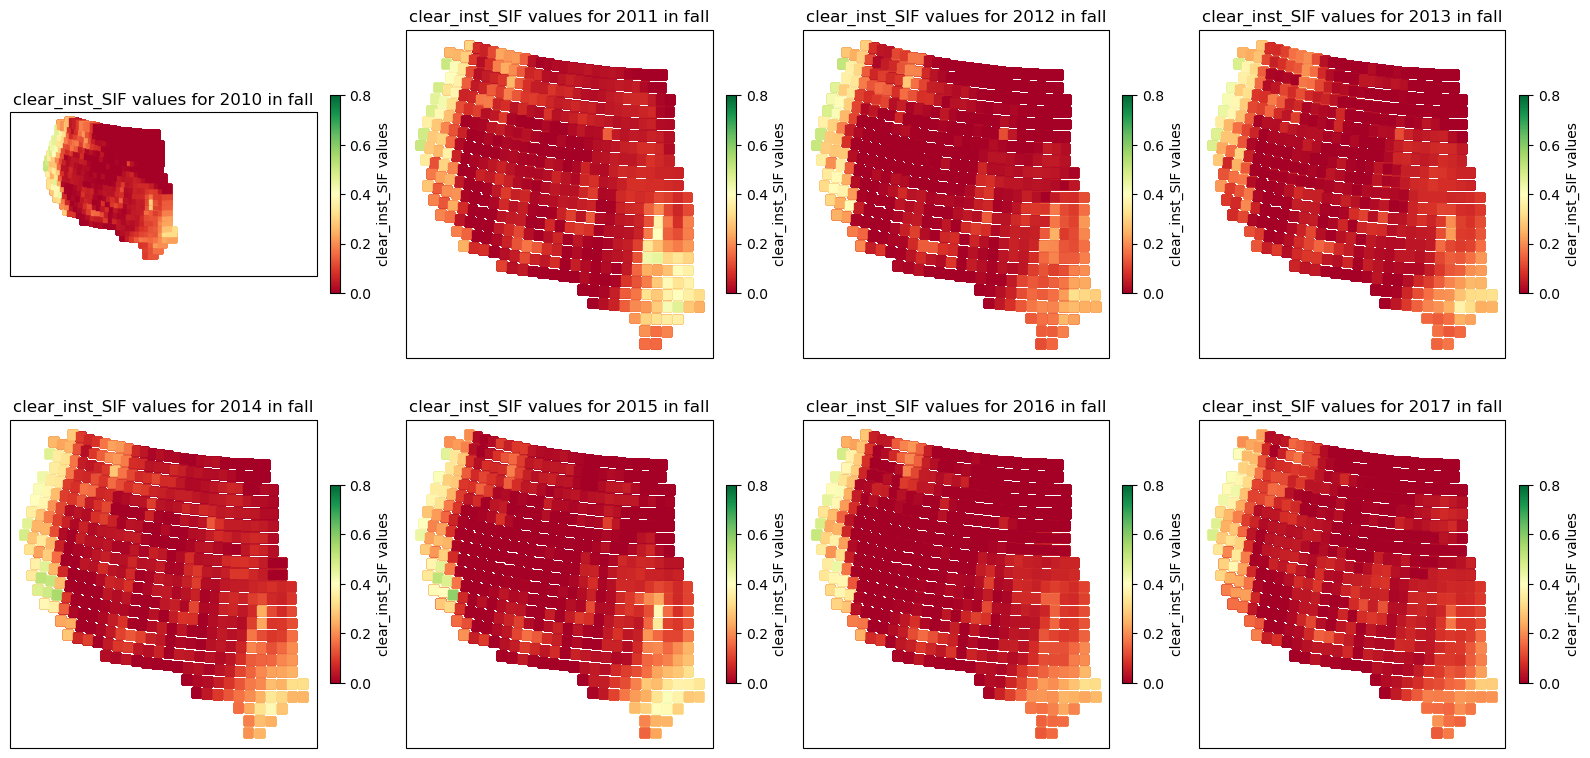

In [106]:


import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

season_to_study = 3
# Créer une figure et des axes pour les graphiques
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), subplot_kw={'projection': ccrs.LambertConformal()})

# Définir la zone d'affichage de la carte sur les États-Unis
axes[0, 0].set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())


# Parcourir les années de 2010 à 2017
for i, year_to_study in enumerate(range(2010, 2018)):
    # Calculer les indices de la position des graphiques
    row = i // 4
    col = i % 4

    # Sélectionner les axes correspondants à l'année en cours
    ax = axes[row, col]

    filtered_df = df_csif[df_csif['start_date'].dt.year == year_to_study]
    filtered_df.groupby(['lat', 'lon', 'season'])['clear_inst_SIF'].mean()
    filtered_df = filtered_df[(filtered_df['season'] == season_to_study)]
    marker_size = 40

    sc = ax.scatter(filtered_df['lon'], filtered_df['lat'], c=filtered_df['clear_inst_SIF'], marker='s', s=marker_size, cmap='RdYlGn', transform=ccrs.PlateCarree(), vmin=0, vmax=0.8)

    # Ajouter une barre de couleur pour représenter les valeurs de 'skill'
    cbar = plt.colorbar(sc, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('clear_inst_SIF values')

    # Ajouter un titre à la carte
    ax.set_title('clear_inst_SIF values for {} in {}'.format(year_to_study, string_season(season_to_study)))

# Ajuster les espaces autour des graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()


In [93]:
def pointwise_skill_computation(df,year):
    """
    we need to group by latitude and longitude to form batches per season. 
    we then perform skill computation on every batch
    """
    tic()
    df.reset_index(inplace=True,drop=True)
    skills_with_clear_inst_SIF=[]
    skills_without_clear_inst_SIF=[]

    # Groupement par lot (batch) en fonction des valeurs de 'lat' et 'lon'
    groups = df.groupby(['lat','lon','season'])

    # Parcourir chaque groupe et calculer la valeur de skill pour les colonnes '2015' et '2016'
    for _, group in groups:
        # Obtenir les valeurs des colonnes '2015' et '2016' pour le batch actuel

        # Calculer la valeur de skill pour le batch actuel
        skill_with_csif=get_col_skill(group,'preds with csif','ground truth',date_col='start_date')
        skill_without_csif=get_col_skill(group,'preds without csif','ground truth',date_col='start_date')
        
        skills_with_clear_inst_SIF.append(skill_with_csif)
        skills_without_clear_inst_SIF.append(skill_without_csif)

        # Mettre à jour la colonne 'skill' du batch actuel avec les valeurs calculées
        df.loc[group.index, 'skill with csif'] = skill_with_csif
        df.loc[group.index, 'skill without csif'] = skill_without_csif

    toc()
    return df

In [94]:
for year in range(2011,2018):
    df_name='df{}'.format(year)
    df=globals()[df_name]
    df=pointwise_skill_computation(df,year)
    globals()[df_name]=df
    


Elapsed time: 138.888438 seconds.

Elapsed time: 139.467447 seconds.

Elapsed time: 140.740700 seconds.

Elapsed time: 138.822146 seconds.

Elapsed time: 138.026316 seconds.

Elapsed time: 137.352797 seconds.

Elapsed time: 137.528177 seconds.



In [98]:
print(df2012)

       start_date  ground truth  season  preds without csif  preds with csif  \
0      2012-01-01      0.074375       4            0.657691         0.575894   
1      2012-01-02      0.113179       4            0.657691         0.692066   
2      2012-01-03      0.756123       4            0.699327         0.620537   
3      2012-01-04      1.612754       4            0.547336         0.585492   
4      2012-01-05      1.556267       4            0.312155         0.338635   
...           ...           ...     ...                 ...              ...   
187605 2012-12-27      3.238035       4            0.201165        -0.553012   
187606 2012-12-28      4.364917       4            0.117264        -0.760424   
187607 2012-12-29      4.721058       4            0.005551        -0.692057   
187608 2012-12-30      4.405504       4            0.309852         1.159128   
187609 2012-12-31      3.829896       4            1.173665         0.706087   

         lat    lon  skill with csif  s

In [97]:
for year in range(2011,2018):
    tic()
    df_name='df{}'.format(year)
    df=globals()[df_name]
    df['skill improvement']=(df['skill with csif']-df['skill without csif'])/df['skill without csif']*100
    globals()[df_name]=df
    toc()


Elapsed time: 0.002630 seconds.

Elapsed time: 0.001988 seconds.

Elapsed time: 0.002026 seconds.

Elapsed time: 0.001934 seconds.

Elapsed time: 0.001863 seconds.

Elapsed time: 0.001783 seconds.

Elapsed time: 0.001828 seconds.



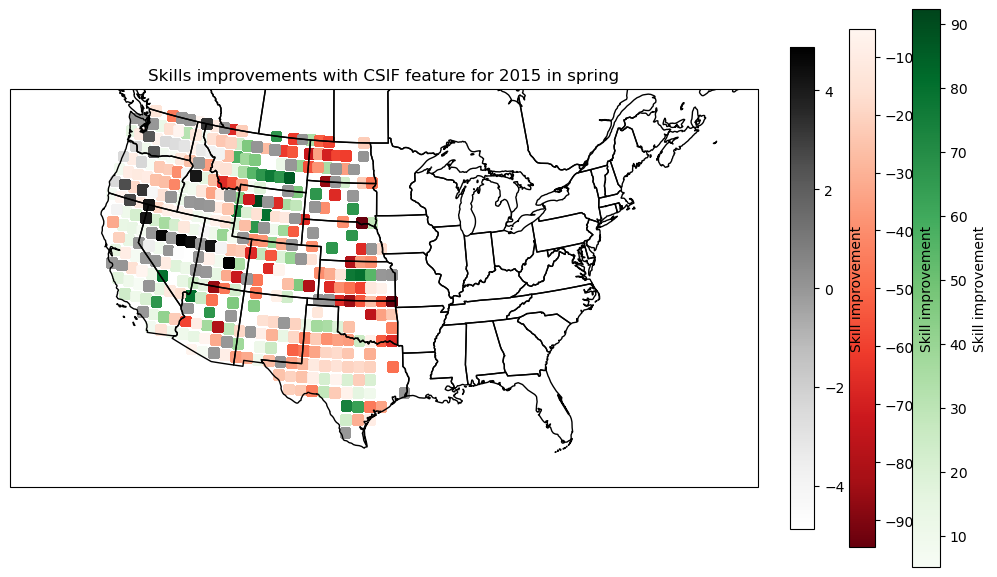

In [117]:


import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

season_to_study=1
year_to_study=2015
limit=20
df_name='df{}'.format(year_to_study)
df=globals()[df_name]

# Supposons que votre DataFrame s'appelle df avec les colonnes 'latitude', 'longitude' et 'skill'

# Créer une figure et des axes pour la carte
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.LambertConformal()})

# Définir la zone d'affichage de la carte sur les États-Unis
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

# Charger les limites des États-Unis avec cartopy
ax.add_feature(cartopy.feature.STATES)

# Filtrer les données pour exclure les points avec 'skill improvement' > 500
#filtered_df = df[(df['skill improvement'] <= limit)&(df['season']==season_to_study)&(df['skill improvement'] >= -limit)]
filtered_df1 = df[(df['skill improvement'] <= 100)&(df['season']==season_to_study)&(df['skill improvement'] >= 5)]
filtered_df2 = df[(df['skill improvement'] <= -5)&(df['season']==season_to_study)&(df['skill improvement'] >= -100)]
filtered_df3 = df[(df['skill improvement'] <= 5)&(df['season']==season_to_study)&(df['skill improvement'] >= -5)]


marker_size=40
sc1 = ax.scatter(filtered_df1['lon'], filtered_df1['lat'], c=filtered_df1['skill improvement'], marker='s', s=marker_size,cmap='Greens', transform=ccrs.PlateCarree())
sc2 = ax.scatter(filtered_df2['lon'], filtered_df2['lat'], c=filtered_df2['skill improvement'],marker='s', s=marker_size, cmap='Reds_r', transform=ccrs.PlateCarree())
sc3 = ax.scatter(filtered_df3['lon'], filtered_df3['lat'], c=filtered_df3['skill improvement'],marker='s', s=marker_size, cmap='Greys', transform=ccrs.PlateCarree())



# Ajouter une barre de couleur pour représenter les valeurs de 'skill'
cbar1 = plt.colorbar(sc1, ax=ax, fraction=0.03, pad=0.04)
cbar1.set_label('Skill improvement')
cbar2 = plt.colorbar(sc2, ax=ax, fraction=0.03, pad=0.04)
cbar2.set_label('Skill improvement')
cbar3 = plt.colorbar(sc3, ax=ax, fraction=0.03, pad=0.04)
cbar3.set_label('Skill improvement')

# Ajouter un titre à la carte
ax.set_title('Skills improvements with CSIF feature for {} in {}'.format(year_to_study,string_season(season_to_study)))

# Afficher la carte
plt.show()

